In [ ]:
# IMPORTS & ENV VARS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings

# suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# set working directory to parent directory
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
os.chdir(parent_dir)
print(f"Changed working directory to: {parent_dir}")

DATA_DIR = os.path.join(parent_dir, 'data')
RESULT_DIR = os.path.join(parent_dir, 'results')
                          
TRAIN_SPLIT_PER = 0.80 
TS_CV_SPLITS = 4

PEAK_WEIGHT_MULTIPLIER = 30

ENABLE_FEATURE_ENGINEERING = True
ENABLE_RFE = True
RFE_STEP = 10

MIN_FEATURES_RFE = 40

LAG_WEEKS = [1, 2, 4, 8, 20, 40]
DELTA_WEEKS = [1, 2, 4, 8, 20, 40]
ROLLING_WEEKS = [4, 8, 12, 20, 40]

LGBM_PARAM_GRID = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30]
}

In [20]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [21]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill only)
    # We avoid bfill() to prevent data leakage from the future.
    # LightGBM can handle any remaining NaNs natively.
    df = df.ffill()
    
    return df

# Apply to San Juan and Iquitos
sj_train_full = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train_full = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train_full.shape)
print("Iquitos Preprocessed Shape:", iq_train_full.shape)
sj_train_full.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [22]:
# SPLIT DATA (TRAIN / TEST)

def split_time_series(df, train_ratio=TRAIN_SPLIT_PER):
    """
    Splits time series data into Train and Test sets.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    
    train = df.iloc[:train_end]
    test = df.iloc[train_end:]
    
    return train, test

# Split San Juan
sj_train, sj_test = split_time_series(sj_train_full)

# Split Iquitos
iq_train, iq_test = split_time_series(iq_train_full)

print("San Juan Splits:")
print(f"Train: {sj_train.shape}, Test: {sj_test.shape}")

print("\nIquitos Splits:")
print(f"Train: {iq_train.shape}, Test: {iq_test.shape}")

San Juan Splits:
Train: (748, 23), Test: (188, 23)

Iquitos Splits:
Train: (416, 23), Test: (104, 23)


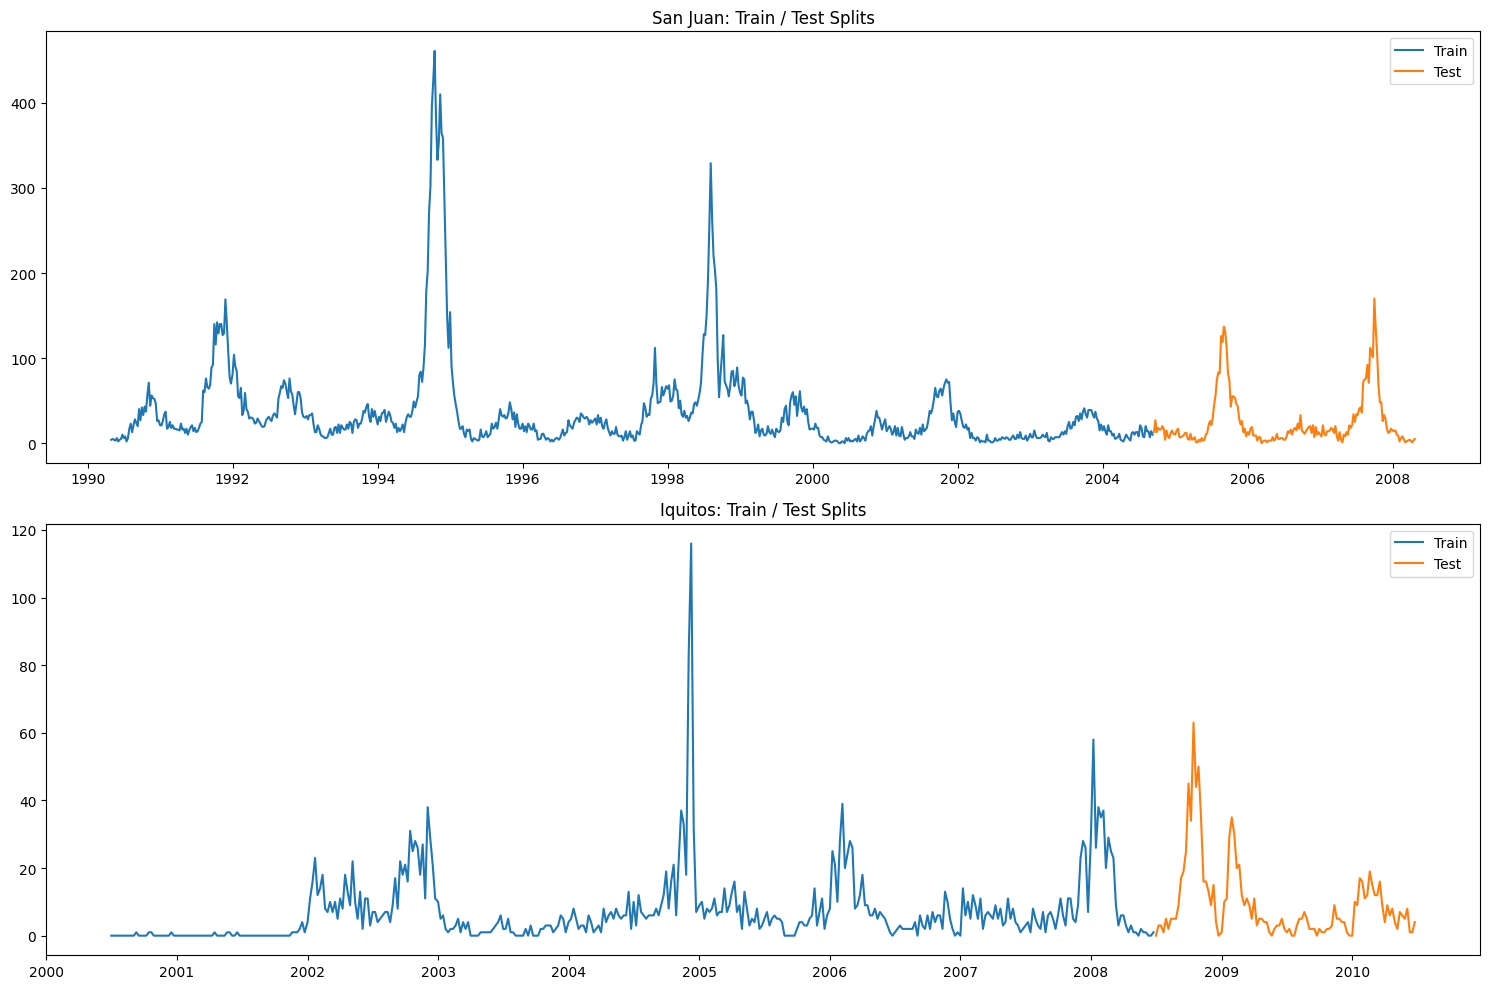

In [23]:
# VISUALIZE SPLITS

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# San Juan
ax[0].plot(sj_train.index, sj_train['total_cases'], label='Train')
ax[0].plot(sj_test.index, sj_test['total_cases'], label='Test')
ax[0].set_title('San Juan: Train / Test Splits')
ax[0].legend()

# Iquitos
ax[1].plot(iq_train.index, iq_train['total_cases'], label='Train')
ax[1].plot(iq_test.index, iq_test['total_cases'], label='Test')
ax[1].set_title('Iquitos: Train / Test Splits')
ax[1].legend()

plt.tight_layout()
plt.show()

In [24]:
# FEATURE EXTRACTION

def create_features(df, history_df=None, lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS, rolling_weeks=ROLLING_WEEKS):
    """
    Creates lag, delta, and rolling window features.
    If history_df is provided, it is prepended to df to calculate features for the beginning of df.
    
    Includes autoregressive features from 'total_cases' ensuring no leakage (using shift(1)).
    """
    # Determine max window size needed
    max_window = max(max(lag_weeks), max(rolling_weeks)) + 1
    
    # Prepare dataframe for engineering
    if history_df is not None:
        # Take tail of history
        history_tail = history_df.tail(max_window)
        # Concatenate
        df_eng = pd.concat([history_tail, df])
    else:
        df_eng = df.copy()
    
    # 1. Exogenous Features
    # List of columns to create features for (exclude labels and non-numeric if any)
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )
            
        # Delta features
        for delta in delta_weeks:
            new_features.append(
                df_eng[col].diff(delta).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            roll_mean = rolling_col.mean()
            roll_std = rolling_col.std()
            
            new_features.append(roll_mean.rename(f'{col}_rolling_mean_{window}'))
            new_features.append(roll_std.rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))
            
            # Z-score
            z_score = (df_eng[col] - roll_mean) / (roll_std + 1e-8)
            new_features.append(z_score.rename(f'{col}_rolling_zscore_{window}'))

    # 2. Target Autoregressive Features (total_cases)
    # We must ensure NO LEAKAGE. 
    # We can use lags >= 1.
    # For rolling/diffs, we must apply them to a shifted series (shift(1)).
    target_col = 'total_cases'
    if target_col in df_eng.columns:
        # Base series for rolling/diffs (shifted by 1 to be safe)
        target_shifted = df_eng[target_col].shift(1)
        
        # Lags
        for lag in lag_weeks:
            # lag k is safe if k >= 1
            new_features.append(
                df_eng[target_col].shift(lag).rename(f'{target_col}_lag_{lag}')
            )
            
        # Diffs (on shifted data)
        for delta in delta_weeks:
            # y_{t-1} - y_{t-1-delta}
            new_features.append(
                target_shifted.diff(delta).rename(f'{target_col}_lag1_delta_{delta}')
            )
            
        # Rolling (on shifted data)
        for window in rolling_weeks:
            rolling_col = target_shifted.rolling(window=window)
            
            roll_mean = rolling_col.mean()
            roll_std = rolling_col.std()
            
            new_features.append(roll_mean.rename(f'{target_col}_lag1_rolling_mean_{window}'))
            new_features.append(roll_std.rename(f'{target_col}_lag1_rolling_std_{window}'))
            new_features.append(rolling_col.min().rename(f'{target_col}_lag1_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{target_col}_lag1_rolling_max_{window}'))
            
            # Z-score
            z_score = (target_shifted - roll_mean) / (roll_std + 1e-8)
            new_features.append(z_score.rename(f'{target_col}_lag1_rolling_zscore_{window}'))

    # Concatenate all new features
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # If history was used, slice back to original df index
    if history_df is not None:
        df_eng = df_eng.loc[df.index]
    else:
        # If no history (start of train), drop NaNs
        df_eng.dropna(inplace=True)
    
    return df_eng

if ENABLE_FEATURE_ENGINEERING:
    # Apply to San Juan
    print("Feature Engineering San Juan...")
    sj_train_eng = create_features(sj_train)
    # For test, history is train
    sj_test_eng = create_features(sj_test, history_df=sj_train)

    # Apply to Iquitos
    print("Feature Engineering Iquitos...")
    iq_train_eng = create_features(iq_train)
    iq_test_eng = create_features(iq_test, history_df=iq_train)

    print("San Juan Shapes (Train/Test):", sj_train_eng.shape, sj_test_eng.shape)
    print("Iquitos Shapes (Train/Test):", iq_train_eng.shape, iq_test_eng.shape)
else:
    print("Feature Engineering SKIPPED.")
    sj_train_eng = sj_train.copy()
    sj_test_eng = sj_test.copy()
    
    iq_train_eng = iq_train.copy()
    iq_test_eng = iq_test.copy()
    
    print("San Juan Shapes (Train/Test):", sj_train_eng.shape, sj_test_eng.shape)
    print("Iquitos Shapes (Train/Test):", iq_train_eng.shape, iq_test_eng.shape)

Feature Engineering San Juan...
Feature Engineering Iquitos...
San Juan Shapes (Train/Test): (707, 900) (188, 900)
Iquitos Shapes (Train/Test): (375, 900) (104, 900)


In [25]:
# RECURSIVE FEATURE ELIMINATION (RFE)

def recursive_feature_elimination(X_train, y_train, X_val, y_val, min_features=MIN_FEATURES_RFE, step=RFE_STEP, verbose=True):
    """
    Starts with all features and removes the least important ones iteratively.
    Tracks the best subset of features based on Validation MAE.
    Stops when min_features is reached.
    """
    current_features = X_train.columns.tolist()
    best_features = current_features.copy()
    best_mae = float('inf')
    
    # Define a fixed model for selection
    # Using 'poisson' objective as requested
    params = {
        'objective': 'poisson',
        'metric': 'mae',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 31,
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': -1
    }
    
    print(f"Starting Recursive Feature Elimination on {len(current_features)} features (stopping at {min_features}, step={step})...")
    
    # Loop until we reach min_features
    while len(current_features) >= min_features:
        # Train model
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train[current_features], y_train)
        
        # Predict
        preds = model.predict(X_val[current_features])
        preds = np.maximum(preds, 0)
        
        mae = mean_absolute_error(y_val, preds)
        
        # Print progress occasionally
        if verbose:
             print(f"Features: {len(current_features):<3} MAE: {mae:.4f}")
            
        if mae < best_mae:
            best_mae = mae
            best_features = current_features.copy()
            if verbose:
                print(f"   -> New Best MAE at {len(current_features)} features: {best_mae:.4f}")
        
        # If we are at min_features, we stop here (after evaluation)
        if len(current_features) <= min_features:
            break

        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame to sort
        feat_imp_df = pd.DataFrame({
            'feature': current_features,
            'importance': importances
        })
        
        # Sort by importance (ascending)
        feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)
        
        # Identify features to remove (bottom 'step')
        features_to_remove = feat_imp_df['feature'].iloc[:step].tolist()
        
        # Remove them
        for f in features_to_remove:
            if f in current_features:
                current_features.remove(f)
        
    print(f"Selected {len(best_features)} features. Final MAE: {best_mae:.4f}")
    return best_features

In [26]:
# PREPARE X and y MATRICES & SELECT FEATURES

def prepare_xy(df, target_col='total_cases'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

# San Juan
X_train_sj, y_train_sj = prepare_xy(sj_train_eng)
X_test_sj, y_test_sj = prepare_xy(sj_test_eng)

# Iquitos
X_train_iq, y_train_iq = prepare_xy(iq_train_eng)
X_test_iq, y_test_iq = prepare_xy(iq_test_eng)

print("San Juan X Shapes (Before Selection):", X_train_sj.shape)
print("Iquitos X Shapes (Before Selection):", X_train_iq.shape)

if ENABLE_RFE:
    # Apply Recursive Feature Elimination
    # We need a validation set for RFE. Since we merged Train+Val, we'll create a temporary split here.
    # Use last 20% of train as validation for RFE
    
    def get_rfe_split(X, y, split_per=0.8):
        n = len(X)
        idx = int(n * split_per)
        return X.iloc[:idx], y.iloc[:idx], X.iloc[idx:], y.iloc[idx:]

    print("\n--- Feature Selection San Juan ---")
    X_t_rfe_sj, y_t_rfe_sj, X_v_rfe_sj, y_v_rfe_sj = get_rfe_split(X_train_sj, y_train_sj)
    sj_kept_cols = recursive_feature_elimination(X_t_rfe_sj, y_t_rfe_sj, X_v_rfe_sj, y_v_rfe_sj)

    print("\n--- Feature Selection Iquitos ---")
    X_t_rfe_iq, y_t_rfe_iq, X_v_rfe_iq, y_v_rfe_iq = get_rfe_split(X_train_iq, y_train_iq)
    iq_kept_cols = recursive_feature_elimination(X_t_rfe_iq, y_t_rfe_iq, X_v_rfe_iq, y_v_rfe_iq)

    # Update Matrices with Selected Features
    X_train_sj = X_train_sj[sj_kept_cols]
    X_test_sj = X_test_sj[sj_kept_cols]

    X_train_iq = X_train_iq[iq_kept_cols]
    X_test_iq = X_test_iq[iq_kept_cols]

    print("\nSan Juan Selected Shape:", X_train_sj.shape)
    print("Iquitos Selected Shape:", X_train_iq.shape)
else:
    print("\nRecursive Feature Elimination SKIPPED.")
    sj_kept_cols = X_train_sj.columns.tolist()
    iq_kept_cols = X_train_iq.columns.tolist()

San Juan X Shapes (Before Selection): (707, 899)
Iquitos X Shapes (Before Selection): (375, 899)

--- Feature Selection San Juan ---
Starting Recursive Feature Elimination on 899 features (stopping at 40, step=10)...
Features: 899 MAE: 4.1720
   -> New Best MAE at 899 features: 4.1720
Features: 889 MAE: 4.1720
Features: 879 MAE: 4.1720
Features: 869 MAE: 4.1720
Features: 859 MAE: 4.1720
Features: 849 MAE: 4.1720
Features: 839 MAE: 4.1720
Features: 829 MAE: 4.1720
Features: 819 MAE: 4.1720
Features: 809 MAE: 4.1720
Features: 799 MAE: 4.1720
Features: 789 MAE: 4.1720
Features: 779 MAE: 4.1720
Features: 769 MAE: 4.1720
Features: 759 MAE: 4.1720
Features: 749 MAE: 4.1720
Features: 739 MAE: 4.1720
Features: 729 MAE: 4.1720
Features: 719 MAE: 4.1720
Features: 709 MAE: 4.1720
Features: 699 MAE: 4.1720
Features: 689 MAE: 4.1720
Features: 679 MAE: 4.1720
Features: 669 MAE: 4.1720
Features: 659 MAE: 4.1720
Features: 649 MAE: 4.1720
Features: 639 MAE: 4.1720
Features: 629 MAE: 4.1720
Features: 61

In [27]:
X_train_iq.head()

,ndvi_ne_rolling_max_12,ndvi_ne_rolling_kurt_20,ndvi_nw_lag_20,ndvi_nw_rolling_kurt_12,ndvi_se_rolling_kurt_8,ndvi_sw_rolling_max_4,ndvi_sw_rolling_kurt_40,precipitation_amt_mm_delta_4,precipitation_amt_mm_rolling_min_8,precipitation_amt_mm_rolling_zscore_8,...,station_min_temp_c_rolling_kurt_12,station_precip_mm_lag_4,station_precip_mm_rolling_kurt_4,station_precip_mm_rolling_std_12,station_precip_mm_rolling_mean_20,total_cases_lag_1,total_cases_lag_2,total_cases_lag1_rolling_mean_4,total_cases_lag1_rolling_max_4,total_cases_lag1_rolling_std_12
week_start_date,,,,,,,,,,,,,,,,,,,,,
2001-04-16,0.382757,-0.956381,0.289300,-0.697219,0.868363,0.407486,-0.402773,-12.62,47.14,-0.294111,...,0.660936,70.8,-0.604108,41.335772,59.375,0.0,0.0,0.00,0.0,0.000000
2001-04-23,0.382757,-0.946504,0.253800,-0.486791,0.358069,0.407486,-0.198797,-16.05,74.34,-0.672015,...,-0.096226,80.0,2.539875,34.429677,59.170,1.0,0.0,0.25,1.0,0.288675
2001-04-30,0.382757,-0.781301,0.182414,-0.383845,0.015958,0.407486,-0.098275,8.31,74.34,1.287417,...,-0.740399,46.2,2.281318,30.560263,61.680,0.0,1.0,0.25,1.0,0.288675
2001-05-07,0.382757,-0.429571,0.316829,0.007318,-0.199516,0.407486,0.020257,-35.26,45.56,-2.237568,...,-0.275859,120.1,1.768898,29.676145,61.620,0.0,0.0,0.25,1.0,0.288675
2001-05-14,0.382757,-0.697553,0.169057,-1.024861,2.122749,0.303486,-0.016706,-3.65,45.56,-0.313520,...,-0.453400,45.3,-3.817531,33.623594,61.620,0.0,0.0,0.25,1.0,0.288675


In [28]:
X_test_sj.head()

,ndvi_ne_lag_2,ndvi_ne_lag_40,ndvi_ne_delta_4,ndvi_ne_delta_20,ndvi_ne_rolling_kurt_4,ndvi_ne_rolling_zscore_4,ndvi_ne_rolling_kurt_8,ndvi_ne_rolling_std_12,ndvi_ne_rolling_mean_40,ndvi_nw_lag_1,...,total_cases_lag_2,total_cases_lag_4,total_cases_lag1_delta_8,total_cases_lag1_delta_40,total_cases_lag1_rolling_mean_4,total_cases_lag1_rolling_min_4,total_cases_lag1_rolling_max_4,total_cases_lag1_rolling_zscore_4,total_cases_lag1_rolling_mean_8,total_cases_lag1_rolling_zscore_8
week_start_date,,,,,,,,,,,,,,,,,,,,,
2004-09-16,0.041400,-0.147600,0.056550,0.034050,-5.754464,-0.879611,-0.945932,0.049754,-0.027713,0.074925,...,14.0,14.0,-8.0,-19.0,11.25,7.0,14.0,-0.367277,11.750,-0.383845
2004-09-23,0.107600,-0.037533,-0.059450,0.034050,3.993745,-0.512352,-0.353143,0.049684,-0.025771,0.074925,...,10.0,7.0,5.0,-13.0,11.00,7.0,14.0,0.632456,12.375,0.145100
2004-09-30,0.040150,0.020850,-0.007925,0.123875,3.849555,-0.625191,0.377900,0.046644,-0.025455,-0.067450,...,13.0,14.0,20.0,12.0,16.00,10.0,27.0,1.461265,14.875,1.971107
2004-10-07,0.040150,-0.268300,-0.124400,-0.069667,3.720994,-1.490178,-0.668353,0.041505,-0.019167,0.007625,...,27.0,10.0,-7.0,-9.0,15.75,10.0,27.0,-0.360317,14.000,-0.172224
2004-10-14,0.033475,-0.073100,-0.056950,0.008833,-5.770599,-0.862688,-0.669162,0.042752,-0.017760,0.025267,...,13.0,13.0,4.0,3.0,17.75,13.0,27.0,0.037869,14.500,0.585662


Visualizing TimeSeriesSplit on 707 samples...


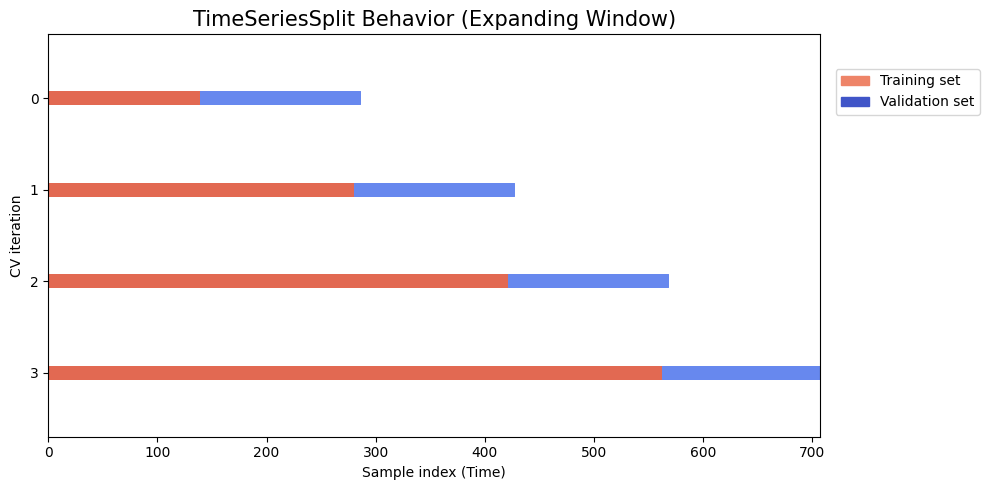

In [29]:
# VISUALIZE ROLLING TIME SERIES CV

from matplotlib.patches import Patch

def plot_cv_indices(cv, X, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training set groups
        indices = np.array([np.nan] * len(X))
        indices[tr] = 1
        indices[tt] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index (Time)', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2], xlim=[0, len(X)])
    ax.set_title('TimeSeriesSplit Behavior (Expanding Window)', fontsize=15)
    
    # Legend
    ax.legend([Patch(color=plt.cm.coolwarm(.8)), Patch(color=plt.cm.coolwarm(.02))],
              ['Training set', 'Validation set'], loc=(1.02, .8))
    
    plt.tight_layout()
    plt.show()

# Visualize the splits on San Juan data (Train)
print(f"Visualizing TimeSeriesSplit on {len(X_train_sj)} samples...")
tscv_viz = TimeSeriesSplit(n_splits=TS_CV_SPLITS)
plot_cv_indices(tscv_viz, X_train_sj, n_splits=TS_CV_SPLITS)

In [30]:
# HYPERPARAMETER TUNING (ROLLING TIME SERIES CV + SAMPLE WEIGHTS)

def get_sample_weights(y, threshold=20, weight_multiplier=PEAK_WEIGHT_MULTIPLIER):
    """
    Assigns higher weights to samples with total_cases > threshold.
    """
    weights = np.ones(len(y))
    # Use .values to ensure alignment if y is a Series
    weights[y.values > threshold] = weight_multiplier
    return weights

def tune_lgbm_rolling(X, y, n_splits=TS_CV_SPLITS):
    """
    Performs Grid Search using TimeSeriesSplit and Sample Weights.
    """
    from itertools import product
    
    param_grid = LGBM_PARAM_GRID
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_mae = float('inf')
    best_params = None
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    print(f"Testing {len(combinations)} combinations with {n_splits}-fold Rolling CV...")
    
    for i, params in enumerate(combinations):
        # Add fixed params
        current_params = params.copy()
        current_params.update({
            'objective': 'poisson',
            'metric': 'mae',
            'random_state': 42,
            'verbosity': -1,
            'n_estimators': 2000 # Higher cap, controlled by early stopping
        })
        
        cv_maes = []
        
        for train_idx, val_idx in tscv.split(X):
            X_t, X_v = X.iloc[train_idx], X.iloc[val_idx]
            y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]
            
            # Generate weights for this fold's training set
            weights = get_sample_weights(y_t)
            
            model = lgb.LGBMRegressor(**current_params)
            
            callbacks = [lgb.early_stopping(stopping_rounds=30, verbose=False)]
            
            model.fit(X_t, y_t, 
                      sample_weight=weights,
                      eval_set=[(X_v, y_v)],
                      eval_metric='mae',
                      callbacks=callbacks)
            
            preds = model.predict(X_v)
            preds = np.maximum(preds, 0)
            mae = mean_absolute_error(y_v, preds)
            cv_maes.append(mae)
            
        avg_mae = np.mean(cv_maes)
        
        if avg_mae < best_mae:
            best_mae = avg_mae
            best_params = params
            # print(f"New Best Avg MAE: {best_mae:.4f} with {params}")
            
    print("\nBest Parameters:", best_params)
    print("Best CV MAE:", best_mae)
    
    # Retrain best model on all provided data (X, y) to return
    final_weights = get_sample_weights(y)
    best_model = lgb.LGBMRegressor(**best_params)
    best_model.set_params(objective='poisson', metric='mae', random_state=42, verbosity=-1, n_estimators=2000)
    best_model.fit(X, y, sample_weight=final_weights)
    
    return best_model, best_params

# Tune San Juan
print("Tuning San Juan Model...")
best_model_sj, best_params_sj = tune_lgbm_rolling(X_train_sj, y_train_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq, best_params_iq = tune_lgbm_rolling(X_train_iq, y_train_iq)

Tuning San Juan Model...
Testing 24 combinations with 4-fold Rolling CV...

Best Parameters: {'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 100, 'min_child_samples': 20}
Best CV MAE: 13.13505261939288

Tuning Iquitos Model...
Testing 24 combinations with 4-fold Rolling CV...

Best Parameters: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100, 'min_child_samples': 20}
Best CV MAE: 5.193074469193218


In [31]:
# RECURSIVE PREDICTION EXPLANATION

# Since we are using autoregressive features (lags of `total_cases`), we cannot simply predict the Test set in one go using `model.predict(X_test)`. 
# In a real forecasting scenario, we do not know the `total_cases` for the first week of the test set to calculate the lag for the second week.

# Therefore, we must use Recursive Prediction:
# 1. Predict t.
# 2. Use the predicted y^_t as the actual y_t to calculate features for t+1.
# 3. Predict t+1.
# 4. Repeat.

# The following cell implements this loop for the Test set evaluation.

Evaluating San Juan (Recursive)...
Starting recursive prediction for 188 steps...
San Juan Test Set MAE (Recursive): 18.2689

Evaluating Iquitos (Recursive)...
Starting recursive prediction for 104 steps...
Iquitos Test Set MAE (Recursive): 7.0331


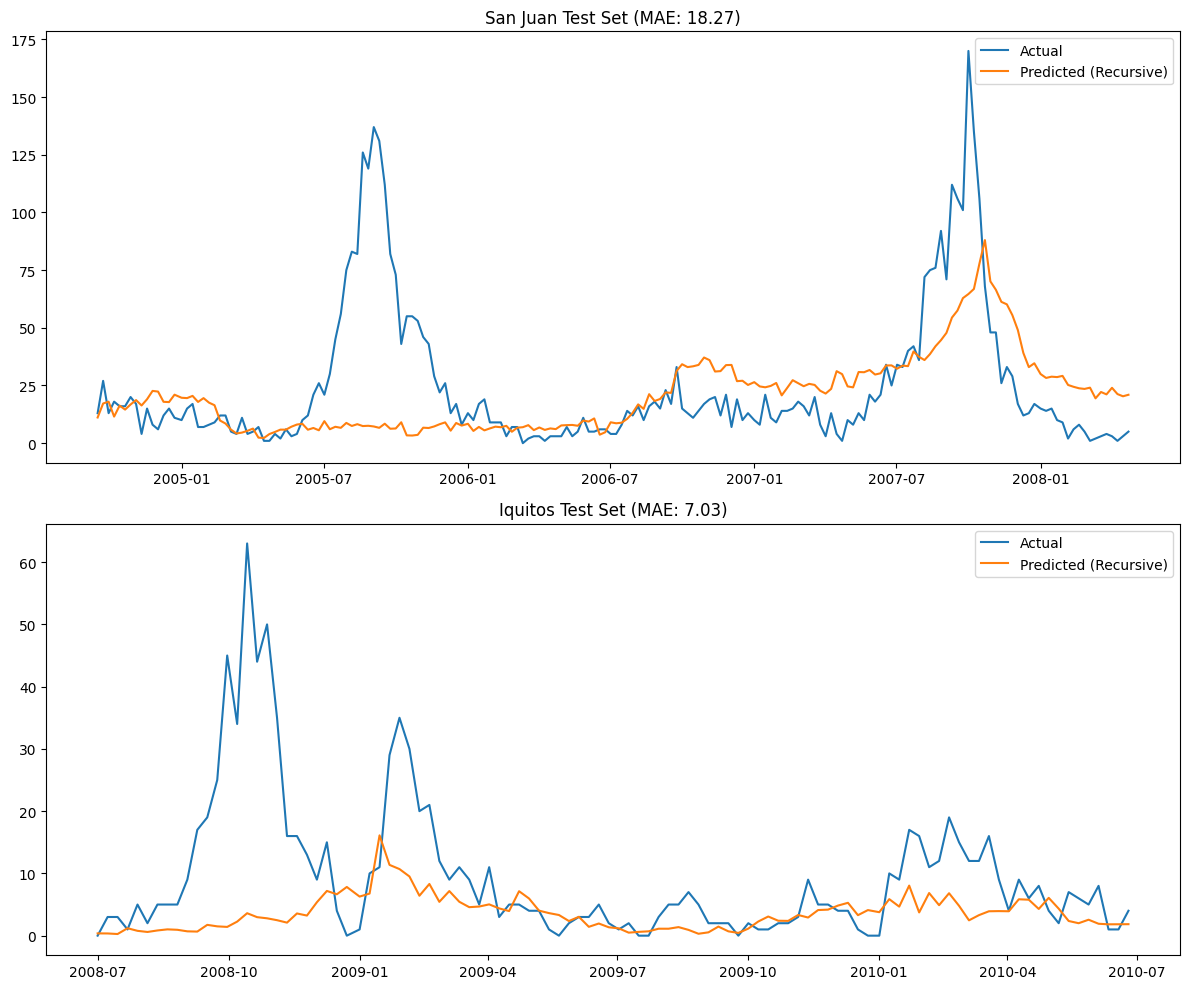

In [32]:
# EVALUATION ON TEST SET (HOLDOUT) - RECURSIVE PREDICTION

def recursive_predict(model, df_test_raw, history_df, feature_eng_func, feature_cols_needed):
    """
    Predicts recursively for the test set.
    df_test_raw: Test data with exogenous features (and 'total_cases' which we will ignore/overwrite).
    history_df: History data with 'total_cases'.
    """
    predictions = []
    current_history = history_df.copy()
    
    # Ensure df_test_raw doesn't have total_cases or we ignore it
    # We will iterate and predict one by one
    
    print(f"Starting recursive prediction for {len(df_test_raw)} steps...")
    
    for i in range(len(df_test_raw)):
        # Get current row
        current_row = df_test_raw.iloc[[i]].copy()
        
        # If total_cases exists (ground truth), drop it to simulate real test scenario
        if 'total_cases' in current_row.columns:
            current_row = current_row.drop(columns=['total_cases'])
            
        # Engineer features
        # create_features will use history + current_row
        # It will generate lags from history.
        eng_row = feature_eng_func(current_row, history_df=current_history)
        
        # Select features
        X_step = eng_row[feature_cols_needed]
        
        # Predict
        pred = model.predict(X_step)[0]
        pred = max(0, pred)
        predictions.append(pred)
        
        # Update history with PREDICTED value
        current_row['total_cases'] = pred
        current_history = pd.concat([current_history, current_row])
        
    return np.array(predictions)

# 1. San Juan Evaluation
print("Evaluating San Juan (Recursive)...")
# We need the raw sj_test (before engineering)
# But sj_test variable from earlier cell IS the raw split (with total_cases).
# We also need the feature columns used by the model.
sj_features_needed = X_train_sj.columns.tolist()

# History is Train
sj_history = sj_train.copy()

preds_sj_test = recursive_predict(best_model_sj, sj_test, sj_history, create_features, sj_features_needed)
mae_sj_test = mean_absolute_error(y_test_sj, preds_sj_test)
print(f"San Juan Test Set MAE (Recursive): {mae_sj_test:.4f}")


# 2. Iquitos Evaluation
print("\nEvaluating Iquitos (Recursive)...")
iq_features_needed = X_train_iq.columns.tolist()
iq_history = iq_train.copy()

preds_iq_test = recursive_predict(best_model_iq, iq_test, iq_history, create_features, iq_features_needed)
mae_iq_test = mean_absolute_error(y_test_iq, preds_iq_test)
print(f"Iquitos Test Set MAE (Recursive): {mae_iq_test:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_test, label='Predicted (Recursive)')
ax[0].set_title(f'San Juan Test Set (MAE: {mae_sj_test:.2f})')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_test, label='Predicted (Recursive)')
ax[1].set_title(f'Iquitos Test Set (MAE: {mae_iq_test:.2f})')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# VISUALIZE FINAL FIT (ACTUAL vs PREDICTED on FULL HISTORY)

# 1. Prepare Full Data
X_full_sj = pd.concat([X_train_sj, X_test_sj])
y_full_sj = pd.concat([y_train_sj, y_test_sj])

X_full_iq = pd.concat([X_train_iq, X_test_iq])
y_full_iq = pd.concat([y_train_iq, y_test_iq])

# 3. Predict on Full History
preds_full_sj = best_model_sj.predict(X_full_sj)
preds_full_sj = np.maximum(preds_full_sj, 0)

preds_full_iq = best_model_iq.predict(X_full_iq)
preds_full_iq = np.maximum(preds_full_iq, 0)

# 4. Calculate Full MAE
mae_full_sj = mean_absolute_error(y_full_sj, preds_full_sj)
mae_full_iq = mean_absolute_error(y_full_iq, preds_full_iq)

print(f"San Juan Full History MAE: {mae_full_sj:.4f}")
print(f"Iquitos Full History MAE: {mae_full_iq:.4f}")

# 5. Plot
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# San Juan
ax[0].plot(y_full_sj.index, y_full_sj, label='Actual', alpha=0.7, color='blue')
ax[0].plot(y_full_sj.index, preds_full_sj, label='Predicted', alpha=0.7, linestyle='--', color='orange')
ax[0].set_title(f'San Juan: Actual vs Predicted (Full History) - MAE: {mae_full_sj:.2f}')
ax[0].legend()

# Iquitos
ax[1].plot(y_full_iq.index, y_full_iq, label='Actual', alpha=0.7, color='blue')
ax[1].plot(y_full_iq.index, preds_full_iq, label='Predicted', alpha=0.7, linestyle='--', color='orange')
ax[1].set_title(f'Iquitos: Actual vs Predicted (Full History) - MAE: {mae_full_iq:.2f}')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# GENERATE SUBMISSION (RECURSIVE PREDICTION ON COMPETITION TEST SET)

# 1. Load and Preprocess Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

sj_test_sub = preprocess_city_data(sj_test_features)
iq_test_sub = preprocess_city_data(iq_test_features)

print("Submission Test Shapes:")
print("San Juan:", sj_test_sub.shape)
print("Iquitos:", iq_test_sub.shape)

# 2. Predict Recursively
# History is the FULL training data (Train + Val + Holdout)
sj_history_full = sj_train_full.copy()
iq_history_full = iq_train_full.copy()

print("\nGenerating Predictions for San Juan...")
preds_sj_sub = recursive_predict(best_model_sj, sj_test_sub, sj_history_full, create_features, sj_features_needed)

print("Generating Predictions for Iquitos...")
preds_iq_sub = recursive_predict(best_model_iq, iq_test_sub, iq_history_full, create_features, iq_features_needed)

# 3. Create Submission DataFrame
submission = pd.read_csv(os.path.join(DATA_DIR, 'submission_format.csv'))

# Fill values
# We need to ensure the order matches. 
# The submission format has city, year, weekofyear.
# Our preds are in time order.
# sj comes first in submission file usually, but let's be safe.

# Assign San Juan
submission.loc[submission['city'] == 'sj', 'total_cases'] = preds_sj_sub.astype(int)

# Assign Iquitos
submission.loc[submission['city'] == 'iq', 'total_cases'] = preds_iq_sub.astype(int)

# 4. Save
submission_path = os.path.join(RESULT_DIR, 'submission_recursive_lgbm.csv')
submission.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")
submission.head()